**os**: Used for interacting with the operating system, such as handling file paths, directory operations, and other system-level operations.

**matplotlib.pyplot and matplotlib.image (mpimg): **Libraries from Matplotlib for plotting graphs and displaying images, respectively. These will likely be used to visualize the dataset and results.

**seaborn: **A data visualization library built on top of Matplotlib. It provides more visually appealing and informative graphs, and will likely be used for plotting performance metrics or confusion matrices.

**Sequential: **A model that lets you create a linear stack of layers.

**layers: **This imports all the available layers like Dense, Conv2D, Dropout, etc., which are commonly used for building neural networks.

**Conv2D and MaxPooling2D: **These are commonly used in convolutional neural networks (CNNs). Conv2D is used to apply convolutional filters to images, and MaxPooling2D is used for down-sampling.

**Dropout:** A regularization technique used to prevent overfitting by randomly dropping units during training.

**Flatten:** Used to flatten the output from convolutional layers into a single vector before passing it to fully connected (dense) layers.

**GlobalMaxPooling2D: **This layer is a variant of Max Pooling, which returns the maximum value from the entire feature map.

**Activation: **Adds an activation function to layers.

**ImageDataGenerator and load_img:** Tools from Keras for image preprocessing and loading images. ImageDataGenerator is often used for augmenting image datasets by applying transformations like rotation, flipping, etc.

**to_categorical: **Converts a class vector (integers) to a one-hot encoded matrix.

**image_dataset_from_directory:** Loads images from a directory and creates a dataset from them, which can be used for model training.

**VGG16 and ResNet50:** Pre-trained models used for transfer learning. These models are very deep CNNs trained on large datasets like ImageNet. In this case, they may be used to classify the “dogs vs. cats” dataset.

**RMSprop: **An optimizer that is often used in deep learning for adjusting the learning rate during training.

**ReduceLROnPlateau and EarlyStopping:** Callbacks used to improve training. ReduceLROnPlateau reduces the learning rate if the model performance plateaus, while EarlyStopping stops training early if the model’s performance stops improving to prevent overfitting.

**confusion_matrix:** From sklearn, used to evaluate the performance of the classification model by showing the number of correct and incorrect predictions for each class.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [6]:
torch.cuda.is_available()

True

In [7]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [4]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import losses, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from keras.utils import to_categorical, image_dataset_from_directory
from keras.models import Sequential
from keras import layers,applications
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, Activation
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
import numpy as np

In [20]:
!unzip "drive/MyDrive/CUDA/train"
!unzip "drive/MyDrive/CUDA/test"


Streaming output truncated to the last 5000 lines.
  inflating: test/5499.jpg           
  inflating: test/55.jpg             
  inflating: test/550.jpg            
  inflating: test/5500.jpg           
  inflating: test/5501.jpg           
  inflating: test/5502.jpg           
  inflating: test/5503.jpg           
  inflating: test/5504.jpg           
  inflating: test/5505.jpg           
  inflating: test/5506.jpg           
  inflating: test/5507.jpg           
  inflating: test/5508.jpg           
  inflating: test/5509.jpg           
  inflating: test/551.jpg            
  inflating: test/5510.jpg           
  inflating: test/5511.jpg           
  inflating: test/5512.jpg           
  inflating: test/5513.jpg           
  inflating: test/5514.jpg           
  inflating: test/5515.jpg           
  inflating: test/5516.jpg           
  inflating: test/5517.jpg           
  inflating: test/5518.jpg           
  inflating: test/5519.jpg           
  inflating: test/552.jpg            

os.makedirs: This creates the subdirectories 'dogs' and 'cats' inside the 'train' directory.

os.listdir(base_dir): Lists all the files in the 'train' directory.

os.path.isfile(file_path): Ensures that the current item is a file (and not a subdirectory).

shutil: move image files into specific subdirectories for organization.

In [21]:
base_dir = 'train'
os.makedirs(os.path.join(base_dir, 'dogs'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'cats'), exist_ok=True)

for filename in os.listdir(base_dir):
    file_path = os.path.join(base_dir, filename)
    if os.path.isfile(file_path):
        if filename.startswith('dog'):
            shutil.move(file_path, os.path.join(base_dir, 'dogs', filename))
        elif filename.startswith('cat'):
            shutil.move(file_path, os.path.join(base_dir, 'cats', filename))

In [22]:
#Create tensorflow dataset with image_dataset_from_directory
#resize all image to 256 pixels.
image_size = (256, 256)
batch_size = 64 #64 images per batch

train_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels='inferred',#Keras will automatically infer the labels based on the directory names.
    label_mode='binary',#Each image will be associated with a binary label (0 for cat , 1 for dog )
    image_size=image_size,#Neural networks expect fixed-size inputs, and resizing ensures that all images are of uniform size.
    interpolation='nearest',#selects the value of the nearest pixel when resizing
    batch_size=batch_size,
    shuffle=True
    #batches have a random mix of both classes during training, shuffle the images randomly before creating the batches
)
classNames = train_ds.class_names
classNames


Found 25000 files belonging to 2 classes.


['cats', 'dogs']

A validation set is used to evaluate the model’s performance on data it hasn’t seen during training which balance train and validate the model on separate portions of the dataset, helping to ensure it generalizes well to unseen data.

In [23]:
#Create tensorflow dataset with image_dataset_from_directory validation

validation_ds = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=0.2,
    subset='validation',#take 20% of the data from 'train' for validation
    seed=1337#run again with the same seed, it will produce the same training-validation split
)
classNames = validation_ds.class_names
classNames


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


['cats', 'dogs']

In [24]:
validation_batches = tf.data.experimental.cardinality(validation_ds)#calculates the  number of batches in the validation_ds dataset and store the number of batches in validation_ds
test_df = validation_ds.take(validation_batches // 5)# takes the first 20% of the validation_ds dataset and assigns it to test_df. 20% of the validation data is now being used as a test set
validation_df = validation_ds.skip(validation_batches // 5)#assigns the remaining 80% to validation_df, which will be used as the actual validation set. will be used during training to monitor the model’s performance

In [25]:
#Performance options for dataset
#Autotune is a constant in TensorFlow used to automatically optimize the performance of input and output operations. used to optimize data loading by ensuring that the system can load the data while the model is training
#Prefetch allows data preprocessing and model execution to be performed in parallel.
#Cache caches the dataset data after its first access, so that subsequent operations can access the data directly.
autotune = tf.data.AUTOTUNE
class_names = train_ds.class_names

train_df = train_ds.cache()#cache the dataset in memory after it’s first loaded.
test_df = test_df.cache()

pf_train = train_df.prefetch(buffer_size = autotune)#prefetch() is used to prepare the next batch of data while the current batch is being processed by the model.
pf_test = test_df.prefetch(buffer_size = autotune)
pf_val = validation_df.prefetch(buffer_size = autotune)

In [26]:
#Data augmentation
#Image data generator is not used but keras layers.
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomRotation(0.3))#add a RandomRotation layer that randomly rotates each image by up to 30% (0.3) of 360 degrees.
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))#Add a RandomFlip layer that randomly flips images both horizontally and vertically.
data_augmentation.add(layers.RandomZoom(0.1))#add RandomZoom layer that randomly zooms in on the image by up to 10% (0.1).
data_augmentation.add(layers.RandomContrast(0.2))# Add a RandomContrast layer that randomly changes the contrast of the image by up to 20%.
data_augmentation.add(layers.RandomBrightness(0.2))# Add a RandomBrightness layer that randomly adjusts the brightness of the image by up to 20%.
print ("Each augmented photo looks a bit different, doing the augmentation helps the model become better at recognizing cats and dogs in all kinds of real-world situations. ")


Each augmented photo looks a bit different, doing the augmentation helps the model become better at recognizing cats and dogs in all kinds of real-world situations. 


In [ ]:
#Model
image_size = (256, 256)
image_shape = image_size + (3,)
preprocess_input = applications.resnet50.preprocess_input

base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()

output_layer = layers.Dense(nclass, activation = 'softmax')
inputs = tf.keras.Input(shape = image_shape)
x = preprocess_input(inputs)
x = data_augmentation(x)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 256, 256)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 256, 256)       │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 256, 256, 3)    │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256, 256, 3)    │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 256, 256, 3)    │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50 (Functional)     │ (None, 8, 8, 2048)     │     23,587,712 │ sequential[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ resnet50[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │          4,098 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 23,538,690 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [28]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))#defines the optimizer
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])
history = model.fit(pf_train, validation_data = (pf_val), epochs = 5)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 567s 1s/step - accuracy: 0.7139 - loss: 0.6130 - val_accuracy: 0.8391 - val_loss: 0.3789
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.8564 - loss: 0.3203 - val_accuracy: 0.8589 - val_loss: 0.3352
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 497s 1s/step - accuracy: 0.8592 - loss: 0.3154 - val_accuracy: 0.8584 - val_loss: 0.3344
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 496s 1s/step - accuracy: 0.8627 - loss: 0.3117 - val_accuracy: 0.8574 - val_loss: 0.3347
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.8573 - loss: 0.3174 - val_accuracy: 0.8582 - val_loss: 0.3319


In [ ]:
#predicciones
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)
label_batch = label_batch.reshape(-1)
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
[[1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [1. 0.]
 [1. 1.]
 [0. 0.]
 [0. 0.]
 [1. 1.]
 [1. 0.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<ipython-input-84-eaa309545925>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"Predicted Label: {classNames[int(pred_label)]}, True Label: {classNames[int(random_label)]}")


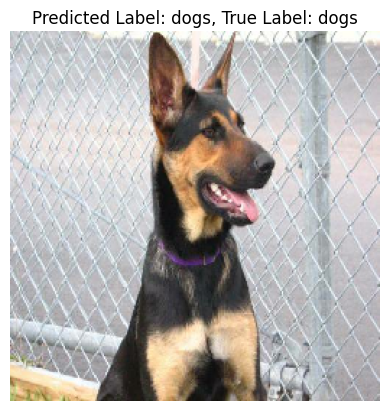

In [84]:
import random
image_batch, label_batch = pf_test.as_numpy_iterator().next()
random_index = random.randint(0, len(image_batch) - 1)
random_image = image_batch[random_index]
random_label = label_batch[random_index]

pred_label = np.argmax(model.predict(np.expand_dims(random_image, axis=0)), axis=1)[0]

plt.imshow(random_image.astype('uint8'))
plt.title(f"Predicted Label: {classNames[int(pred_label)]}, True Label: {classNames[int(random_label)]}")
plt.axis('off')
plt.show()